# Plot SST Predictions

Plots results of "CNN_test_lead.py" script, which used a CNN to predict AMV at various lead times (0-24) for a combination of predictors.


In [173]:
import matplotlib.pyplot as plt
import numpy as np



## User Edits

In [180]:
# Paths
datpath = "/Users/gliu/Downloads/2020_Fall/6.862/Project/CESM_data/proc/LeadTesting/" # path to the data
outpath = "/Users/gliu/Downloads/2020_Fall/6.862/Project/Figures/" # output directory

# Experiment parameters
leadtime   = 25  # Lead time in months (include lag 0)
num_epochs = 10   # Number of Epochs tested for
nmembers   = 42   # Total number of ensemble members used 
netname    = 'CNN2' # Network Type [CNN1,CNN2,FNN,LR]
netlong    = "2-Layer CNN (CNN2)" # Network Long Name

# Save Figures? (Set to True to save to outpath)
savefigures = True

# Set variable names
varnames = ["SST","SSS","PSL","ALL"]

## Load data

In [175]:
%%time
# Load results from CNN lead experiments 

# Set up experiment identifier (ex: CNN2_nepoch10_nens42_lead24)
expname = "%s_nepoch%02i_nens%02i_lead%02i" % (netname,num_epochs,nmembers,leadtime-1)
print("Loading experiment: %s"%expname)

# Preallocate
nvars = len(varnames)
train_loss = np.zeros((nvars,num_epochs,leadtime)) # [variable x epoch x leadtime]
test_loss  = np.zeros(train_loss.shape) # [variable x epoch x leadtime]
test_corr    = np.zeros((nvars,leadtime)) # [variable x leadtime]
train_corr   = np.zeros(test_corr.shape) # [variable x leadtime]

for v,vname in enumerate(varnames):
    vname = varnames[v]

    # Load NPZ file
    results = np.load("%sleadtime_testing_%s_%s.npz"%(datpath,vname,expname))

    # Get correlation for train and test (note, need to rename arrays in future...)
    train_loss[v,:,:] = results['arr_0'].copy() # [n_epochs,lead]
    test_loss[v,:,:] = results['arr_1'].copy()  # [n_epochs,lead] 
    test_corr[v,:] = results['arr_2'].copy()  # [lead,]
    train_corr[v,:] = results['arr_3'].copy() # [lead,]
    
    print("Loaded %s"%vname)


Loading experiment: CNN2_nepoch10_nens42_lead24
Loaded SST
Loaded SSS
Loaded PSL
Loaded ALL
CPU times: user 7.19 ms, sys: 2.1 ms, total: 9.28 ms
Wall time: 7.97 ms


In [176]:
# Load SST autocorrelation for comparison
sst_auto = np.load("../../CESM_Data/SST_autocorrelation_detrended0_latweight1.npy") # [Ensemble x Lag]

sst_auto.shape

(42, 25)

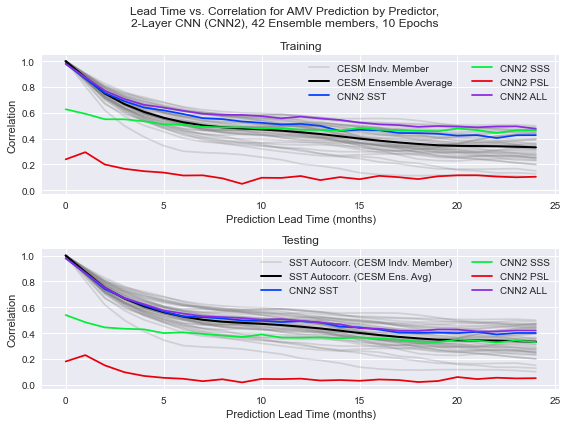

In [185]:
# Plot Lead Time Correlation
fig,axs = plt.subplots(2,1,sharey=True,figsize=(8,6))
plt.style.use('seaborn-bright')

# Plot for training set
ax = axs[0]
for ien in range(42): # Plot CESM Reults
    ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="CESM Indv. Member")
ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="CESM Ensemble Average")
for v in range(nvars): # Plot CNN Results
    ax.plot(train_corr[v,:],label=netname + " " + varnames[v])
ax.legend(ncol=2)  
ax.set_title("Training")
ax.set_ylabel("Correlation")
ax.set_xlabel("Prediction Lead Time (months)")

ax = axs[1]
for ien in range(42): # Plot CESM Reults
    ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="SST Autocorr. (CESM Indv. Member)")
ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="SST Autocorr. (CESM Ens. Avg)")
for v in range(nvars):
    ax.plot(test_corr[v,:],label=netname + " " + varnames[v])
ax.legend(ncol=2)
ax.set_title("Testing")

ax.set_ylabel("Correlation")
ax.set_xlabel("Prediction Lead Time (months)")

plt.suptitle("Lead Time vs. Correlation for AMV Prediction by Predictor,\n" + 
             "%s, %s Ensemble members, %s Epochs"%(netlong,nmembers,num_epochs))
plt.tight_layout()

if savefigures:
    plt.savefig("%sCorrelation_vs_Leadtime_%s.png"%(outpath,expname),dpi=200)
    

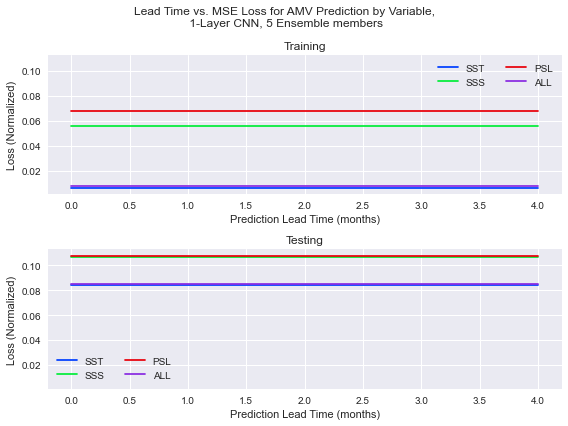

In [75]:
# Plot Losses for each set/variable
fig,axs = plt.subplots(2,1,sharey=True,figsize=(8,6))
plt.style.use('seaborn-bright')

ax = axs[0]
for v in range(nvars):
    ax.plot(train_loss[v,:,:].min(1),label=varnames[v]) # Take minimum loss for all epochs
ax.legend(ncol=2)  
ax.set_title("Training")
ax.set_xlabel("Prediction Lead Time (months)")
ax.set_ylabel("Loss (Normalized)")

ax = axs[1]
for v in range(nvars):
    ax.plot(test_loss[v,:,:].mean(1),label=varnames[v])
ax.legend(ncol=2)
ax.set_title("Testing")
ax.set_ylabel("Loss (Normalized)")
ax.set_xlabel("Prediction Lead Time (months)")

plt.suptitle("Lead Time vs. MSE Loss for AMV Prediction by Variable,\n 1-Layer CNN, 5 Ensemble members")
plt.tight_layout()

if savefigures:
    plt.savefig("%sMSELoss_vs_Leadtime%i_%iepochs_%imembers.png"%(outpath,leadtime,num_epochs,nmembers),dpi=200)

Text(0.5, 1.0, 'Comparing Dataset size')

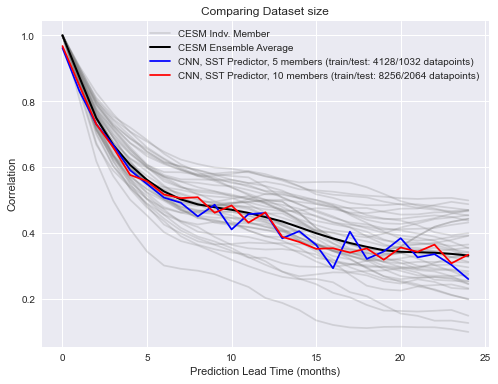

In [96]:
# Compare the result for training for different number of ensembles (10 versus 5)
result10 = np.load("%sleadtime_testing_SST_nens10.npz"%datpath)
train_loss10 = result10['arr_0'].copy() 
test_loss10 = result10['arr_1'].copy()  
test_corr10 = result10['arr_2'].copy()  
train_corr10 = result10['arr_3'].copy() 

# Plot for testing set
fig,ax = plt.subplots(1,1,sharey=True,figsize=(8,6))
plt.style.use('seaborn-bright')
for ien in range(42): # Plot CESM Reults
    ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="CESM Indv. Member")
ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="CESM Ensemble Average")

ax.plot(test_corr[0,:],label="CNN, SST Predictor, 5 members (train/test: %i/%i datapoints)"%(np.fix(1032*5*.8),np.fix(1032*5*.2)),color='b')
ax.plot(test_corr10[:],label="CNN, SST Predictor, 10 members (train/test: %i/%i datapoints)"%(np.fix(1032*10*.8),np.fix(1032*10*.2)),color='r')

ax.legend()

ax.set_xlabel("Prediction Lead Time (months)")
ax.set_ylabel("Correlation")
ax.set_title("Comparing Dataset size")

Text(0.5, 1.0, 'Comparing Dataset size for AMV Prediction, Predictor = SST')

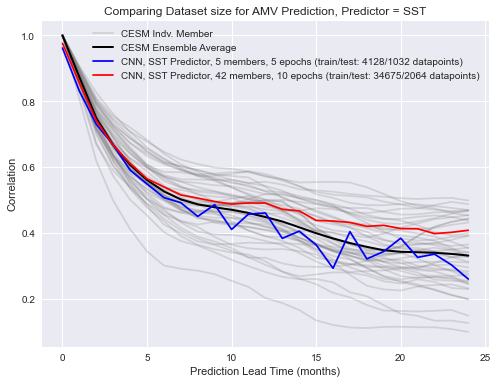

In [119]:
# Compare the result for training for full dataset
vname = 'SST'
vn = varnames.index(vname)


result10 = np.load("%s/1_layer_CNN_All_Data/leadtime_testing_%s_epochs10_nens42.npz"%(datpath,vname))
train_loss10 = result10['arr_0'].copy() 
test_loss10 = result10['arr_1'].copy()  
test_corr10 = result10['arr_2'].copy()  
train_corr10 = result10['arr_3'].copy() 

# Plot for testing set
fig,ax = plt.subplots(1,1,sharey=True,figsize=(8,6))
plt.style.use('seaborn-bright')
for ien in range(42): # Plot CESM Reults
    ax.plot(sst_auto[ien,:], color='gray', alpha=0.25,label="")
ax.plot(sst_auto[ien,:],color='gray',alpha=0.25,label="CESM Indv. Member")
ax.plot(np.mean(sst_auto,axis=0),color='k',linewidth=2,label="CESM Ensemble Average")

ax.plot(test_corr[vn,:],label="CNN, %s Predictor, 5 members, 5 epochs (train/test: %i/%i datapoints)"%(vname,np.fix(1032*5*.8),np.fix(1032*5*.2)),color='b')
ax.plot(test_corr10[:],label="CNN, %s Predictor, 42 members, 10 epochs (train/test: %i/%i datapoints)"%(vname,np.fix(1032*42*.8),np.fix(1032*10*.2)),color='r')

ax.legend()

ax.set_xlabel("Prediction Lead Time (months)")
ax.set_ylabel("Correlation")
ax.set_title("Comparing Dataset size for AMV Prediction, Predictor = %s"% (vname))

In [108]:
vname = 'SST'
vn = varnames.index(vname)
vn

0

/Users/gliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/gliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


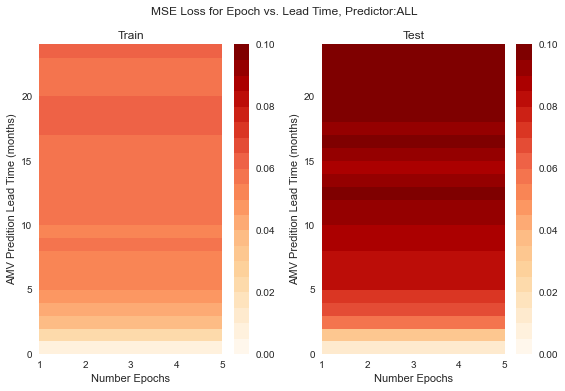

In [153]:
# Plot MSE Loss for Epoch vs Lead time

vname = 'ALL' # Select varable
vn = varnames.index(vname)

# Make plotting values
pepochs = np.arange(1,num_epochs+1,1)
pleads  = np.arange(0,leadtime,1)


fig,axs = plt.subplots(1,2)
cmap = plt.get_cmap('OrRd',20)
plt.style.use('seaborn')

# Plot Train
ax = axs[0]
plotvar = train_loss[v,:,:]
plt.style.use('seaborn')
cmap = plt.get_cmap('OrRd',20)
pcm1 = ax.pcolormesh(pepochs,pleads,plotvar.T,vmin=0,vmax=0.10,cmap=cmap)
fig.colorbar(pcm1,ax=ax)
ax.set_xlabel("Number Epochs")
ax.set_ylabel("AMV Predition Lead Time (months)")
ax.set_title("Train")

# Plot Test
ax = axs[1]
plotvar = test_loss[v,:,:]
pcm2 = ax.pcolormesh(pepochs,pleads,plotvar.T,vmin=0,vmax=0.10,cmap=cmap)
fig.colorbar(pcm2,ax=ax)
ax.set_xlabel("Number Epochs")
ax.set_ylabel("AMV Predition Lead Time (months)")
ax.set_title("Test")
plt.suptitle("MSE Loss for Epoch vs. Lead Time, Predictor:%s"%vname)

plt.tight_layout()

if savefigures:
    plt.savefig("%sLoss_Epoch_vs_Leadtime%i_%s_%iepochs_%imembers.png"%(outpath,leadtime,vname,num_epochs,nmembers),dpi=200)
    
# 1 axis with leading month
# 1 for epoch
# pcolor
# make for the best variable


In [150]:
outpath

'/Users/gliu/Downloads/2020_Fall/6.862/Project/Figures/'